<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/statcan_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.13.5 -q

In [42]:
# file handling
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# eda
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## ETL pipeline

Stats can has tools to make http requests for date from their cube. [1]

In [4]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

I was able to make a request for a single vector, but needed help with transforming the XML output that was extracted. I spent a lot of time trying to write a loop to extract and parse multiple vectors, and ended up using a code generator [2] for the following StatCanETL class:

In [5]:
# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [6]:
class StatCanETL:
    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [7]:
# define table metadata
tables = {
    'name': ['wage', 'raw', 'tax', 'productivity', 'cpi'],
    'tableid': [14100223, 18100268, 11100058, 36100206, 18100004],
    'vector': ['v79311153', 'v1230998135', 'v122807833', 'v1409153', 'v41690973'],
    'description': ['', '', '', '', ''],
    'frequency': ['monthly', 'monthly', 'yearly', 'quarterly', 'monthly'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-Q1', '2001-01'],
    'end': ['2024-12', '2024-12', '2024-12', '2024-Q4', '2024-12']
}

# make df
table_df = pd.DataFrame(tables)

In [8]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing raw...
Data for raw saved to object raw_df
Processing tax...
Data for tax saved to object tax_df
Processing productivity...
Data for productivity saved to object productivity_df
Processing cpi...
Data for cpi saved to object cpi_df


## EDA and cleaning

**check to see if the data loaded correctly:**

In [9]:
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3))

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14
raw_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5
tax_df
      Date  Value
0  2001-01   14.0
1  2002-01   13.8
2  2003-01   13.8
productivity_df
      Date   Value
0  2001-01  85.173
1  2001-04  86.150
2  2001-07  86.665
cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1


Rename columns

In [10]:
wage_df.rename(columns = {'Value': 'wage'}, inplace = True)
raw_df.rename(columns = {'Value': 'raw'}, inplace = True)
tax_df.rename(columns = {'Value': 'tax'}, inplace = True)
productivity_df.rename(columns = {'Value': 'productivity'}, inplace = True)
cpi_df.rename(columns={'Value': 'cpi'}, inplace = True)

Merge tables

In [11]:
data = wage_df.merge(raw_df, on = 'Date', how = 'outer') \
                .merge(tax_df, on = 'Date', how = 'outer') \
                .merge(productivity_df, on = 'Date', how = 'outer') \
                .merge(cpi_df, on = 'Date', how = 'outer')

Because productivity has quarterly observations and tax has yearly observations, the NaN values need to be dealt with. I used forward fill for this.

In [12]:
data = data.ffill()
# if data is missing from the end of a series, then forward fill also fills in those values with the previous entry. just something to keep in mind.

In [13]:
data

,Date,wage,raw,tax,productivity,cpi
0,2001-01,657.14,65.2,14.0,85.173,96.3
1,2001-02,653.59,65.8,14.0,85.173,96.8
2,2001-03,655.14,65.5,14.0,85.173,97.1
3,2001-04,652.44,65.2,14.0,86.150,97.8
4,2001-05,652.28,65.3,14.0,86.150,98.6
...,...,...,...,...,...,...
283,2024-08,1274.25,139.3,13.0,101.372,161.8
284,2024-09,1277.70,134.8,13.0,101.372,161.1
285,2024-10,1284.43,140.3,13.0,101.372,161.8
286,2024-11,1284.43,140.2,13.0,101.372,161.8


In [23]:
# descriptive stats ?skew, ?kurtosis.
data.describe()

,wage,raw,tax,productivity,cpi
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,911.621632,99.128125,12.962500,95.849490,123.738542
std,170.076778,24.307042,0.512271,6.138403,17.143681
min,652.280000,55.300000,12.200000,85.173000,96.300000
25%,772.157500,84.075000,12.600000,91.273250,109.775000
50%,903.520000,97.050000,12.900000,94.349000,122.200000
75%,1009.597500,112.725000,13.125000,100.465500,134.225000
max,1284.430000,166.600000,14.000000,119.771000,162.100000


In [44]:
# categorize variables
numerical_vars = ['wage', 'raw', 'tax', 'productivity', 'cpi']

#### Augmented Dickey-Fuller (ADF) test for stationary time series

In [45]:
# adf test
adf_results_list = []
for feature in numerical_vars:
    adf_results = adfuller(data[feature])
    adf_results_list.append([feature,
                             adf_results[0],
                             adf_results[1],
                             adf_results[4]['5%'],
                             adf_results[4]['10%']])

adf_results_df = pd.DataFrame(adf_results_list, columns=['variable',
                                                         'ADF Statistic',
                                                         'p-value',
                                                         '5%',
                                                         '10%'])
adf_results_df

,variable,ADF Statistic,p-value,5%,10%
0,wage,2.389628,0.999005,-2.872070,-2.572381
1,raw,-1.872810,0.344958,-2.871735,-2.572202
2,tax,-2.063080,0.259617,-2.871699,-2.572183
3,productivity,-1.559950,0.503675,-2.871918,-2.572300
4,cpi,0.792980,0.991522,-2.872147,-2.572422


With the ADF test, the null hypothesis is that the time series has a root unit - this means it is non-stationary. The alternative hypothesis is that the time series is stationary. Given the very large p-values, we fail to reject the null hypothesis: the time series for all 5 variables have a root unit. I'll try some transformations to see if I can make them stationary, as some time series models like ARIMA assume a stationary time series.

In [46]:
# differencing
for var in numerical_vars:
    data[var + '_diff'] = data[var].diff()

data.dropna(inplace = True)

data.head(5)

,Date,wage,raw,tax,productivity,cpi,wage_diff,raw_diff,tax_diff,productivity_diff,cpi_diff
2,2001-03,655.14,65.5,14.0,85.173,97.1,1.55,-0.3,0.0,0.000,0.3
3,2001-04,652.44,65.2,14.0,86.150,97.8,-2.70,-0.3,0.0,0.977,0.7
4,2001-05,652.28,65.3,14.0,86.150,98.6,-0.16,0.1,0.0,0.000,0.8
5,2001-06,656.81,63.9,14.0,86.150,98.7,4.53,-1.4,0.0,0.000,0.1
6,2001-07,656.43,62.7,14.0,86.665,98.4,-0.38,-1.2,0.0,0.515,-0.3


In [48]:
trf_vars = ['wage_diff', 'raw_diff',
            'tax_diff', 'productivity_diff',
            'cpi_diff']

adf_trf_results_list = []
for var in trf_vars:
    adf_trf_results = adfuller(data[var])
    adf_trf_results_list.append([var,
                                 adf_trf_results[0],
                                 adf_trf_results[1],
                                 adf_trf_results[4]['5%'],
                                 adf_trf_results[4]['10%']])

adf_trf_results_df = pd.DataFrame(adf_trf_results_list, columns=['var',
                                                                 'ADF Statistic',
                                                                 'p-value',
                                                                 '5%',
                                                                 '10%'])
adf_trf_results_df


,var,ADF Statistic,p-value,5%,10%
0,wage_diff,-4.618100,1.196024e-04,-2.872070,-2.572381
1,raw_diff,-8.990158,6.926733e-15,-2.871844,-2.572261
2,tax_diff,-16.867500,1.087573e-29,-2.871735,-2.572202
3,productivity_diff,-8.837059,1.707843e-14,-2.871918,-2.572300
4,cpi_diff,-2.920688,4.299459e-02,-2.872147,-2.572422


After differencing the time features, all of the time series features are now stationary. The cpi was not transformed at this time, as I will likely be creating a regression based model.

Next, I'll perform autocorrelation analysis to understand the correlation of each time series with its own lagged values. This will help to identify seasonality, perhaps the cyclical nature of the economy, other trends, and the persistence of values over time.

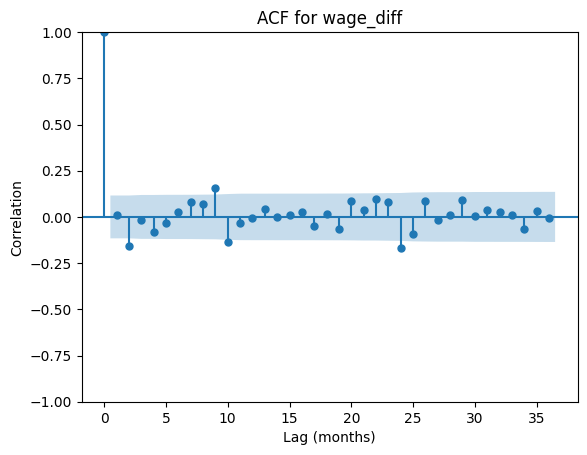

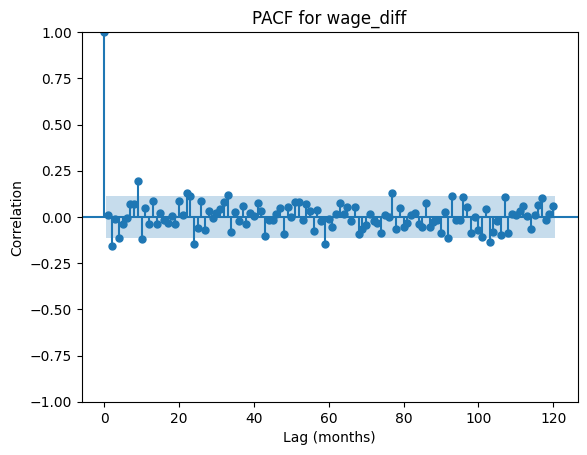

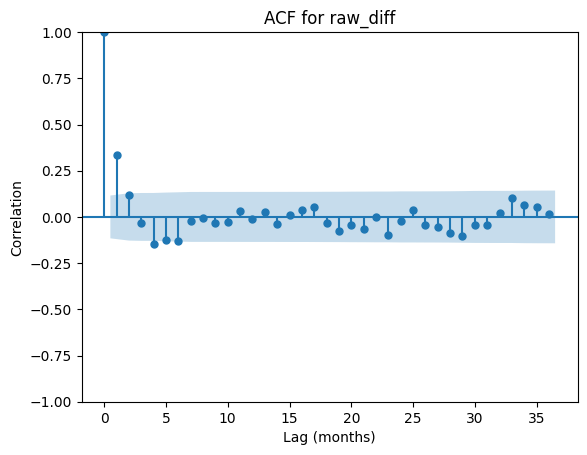

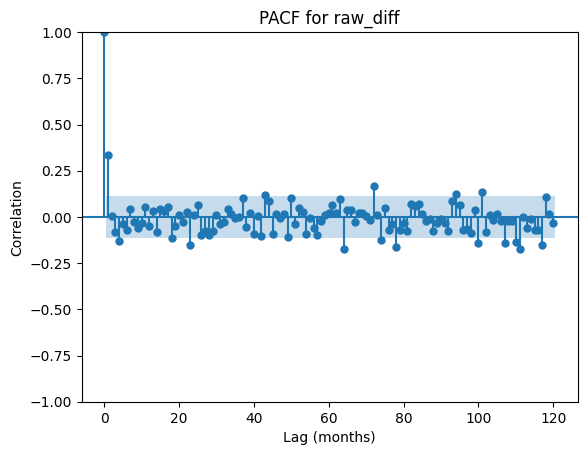

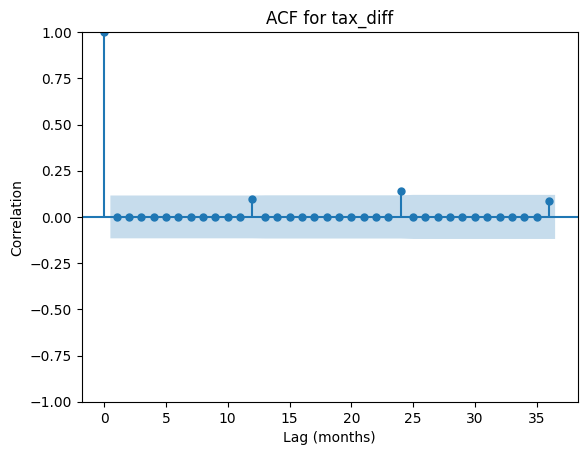

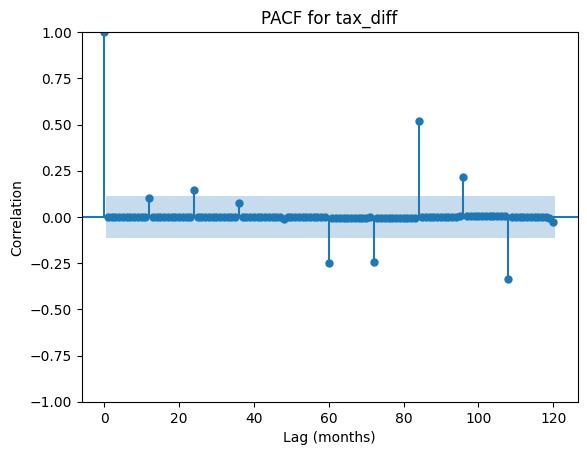

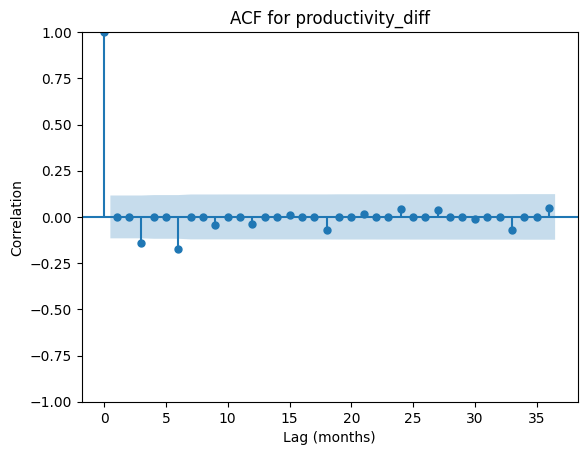

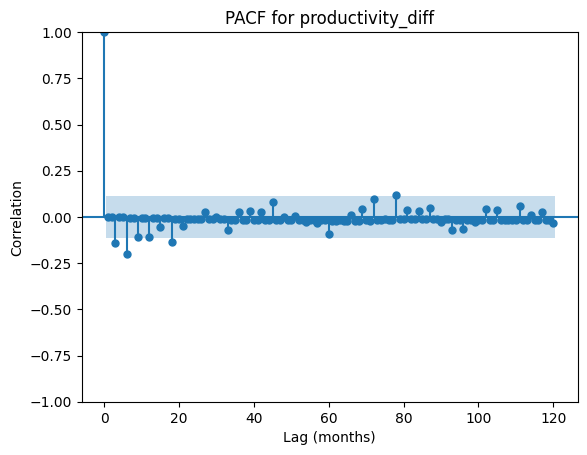

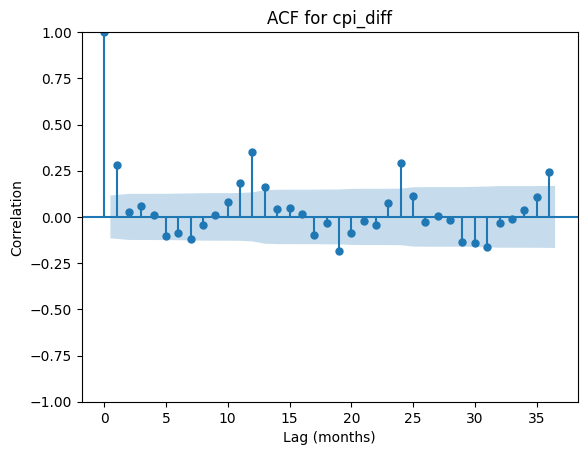

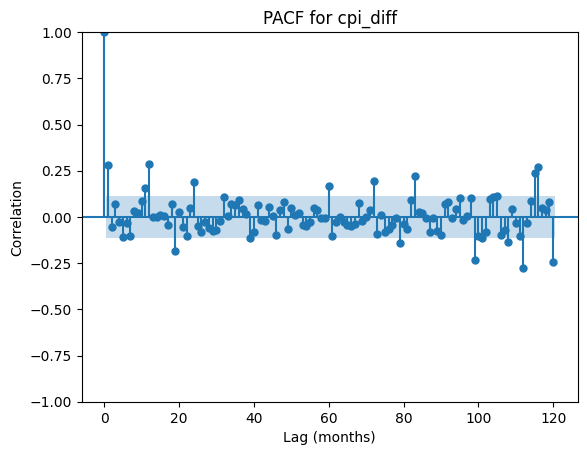

In [50]:
# acf & pcf
for var in trf_vars:
  plot_acf(data[var], lags = 36)
  plt.title(f'ACF for {var}')
  plt.xlabel('Lag (months)')
  plt.ylabel('Correlation')
  plt.show()

  plot_pacf(data[var], lags = 120)
  plt.title(f'PACF for {var}')
  plt.xlabel('Lag (months)')
  plt.ylabel('Correlation')
  plt.show()


Looking at the plots for tax and productivity, we can see the respective yearly and quarterly patterns emerge. Each change in the value of the series is a 'blip' along the line - tax blips occur every 12 months, and productivity blips occur every 3 months, at least at first.

Next up is calculating the cross-correlation between the features and the target,

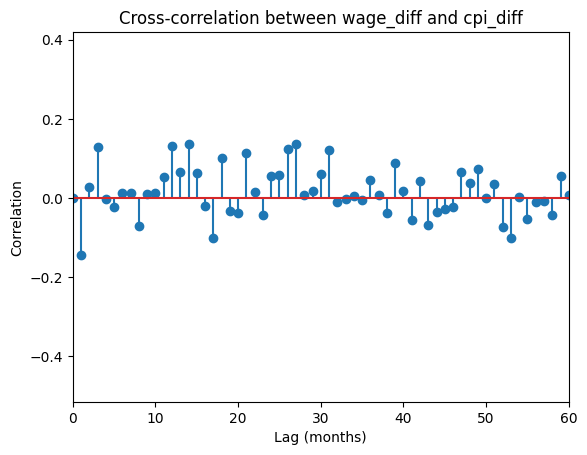

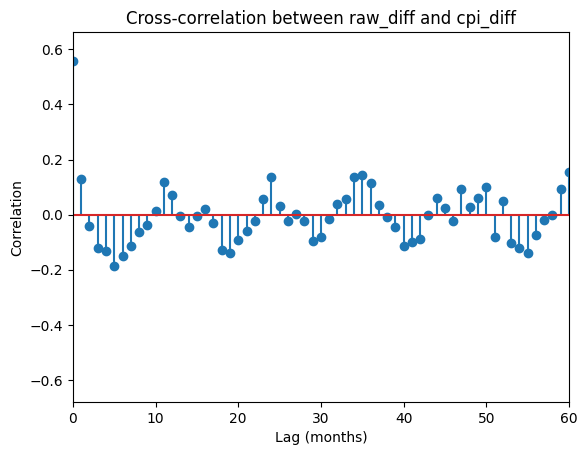

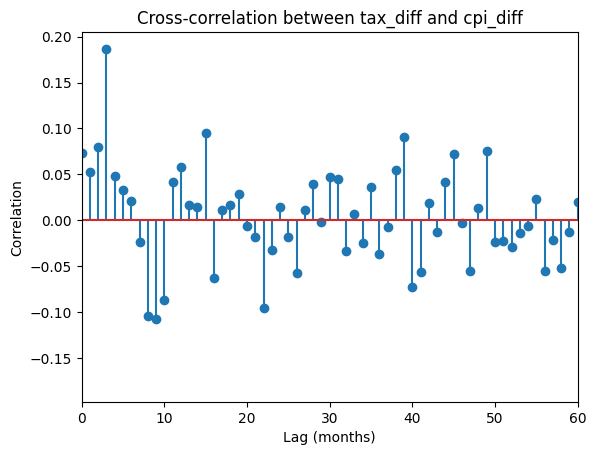

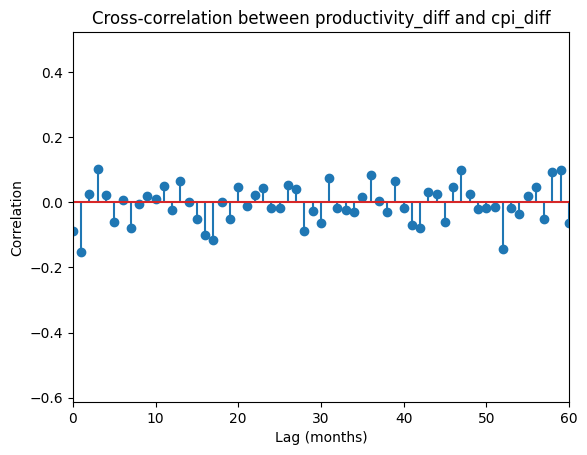

In [53]:
# ccf
x = ['wage_diff', 'raw_diff', 'tax_diff', 'productivity_diff']
y = 'cpi_diff'

for var in x:
  ccf_results = sm.tsa.stattools.ccf(data[var], data[y])
  plt.stem(ccf_results)
  plt.title(f'Cross-correlation between {var} and {y}')
  plt.xlabel('Lag (months)')
  plt.ylabel('Correlation')
  plt.xlim(0, 60)
  plt.show()


1. adf test - ALL TIME SERIES HAVE A UNIT ROOT.
transform with differencing - p-values are now all below the 5% critical value.
ARIMA models do need to difference the target, as they predict the change in the target as opposed to the actual value of the cpi.

2. seasonality and trends
autocorrelation function: ACF and PACF
heatmaps: average values for monthly, seasonal trends.

acf:
wage: maybe at 2, 9, 10, 24
rmpi: 1
tax: maybe 12, 24, 36 > clear annual trend
prod: maybe 3, 6

pacf:
wage: maybe at 2, 9, 24 >
rmpi: 1
tax: same clear annual trend
prod: 3, 6, 9 > apparent theres a quarterly trend.

3. Correlation and relationships
cross correlation analysis for lagged correlations
granger causality
dynamic cross-plots

Interpretation of Cyclical Pattern:

A cyclical pattern in the CCF suggests that there is a recurring relationship between changes in raw material prices and changes in the CPI over time. This means that increases or decreases in raw material prices tend to be followed by similar changes in the CPI after a certain lag, and this pattern repeats periodically.

Possible Explanations:

Economic Cycles: Raw material prices often fluctuate with economic cycles (expansion and contraction). These cycles can also influence the CPI, leading to a cyclical relationship between the two. For example, during economic expansion, demand for raw materials rises, pushing up their prices. This can lead to increased production costs, which eventually get passed on to consumers in the form of higher prices (reflected in the CPI).

Supply and Demand: Cyclical patterns in supply and demand for raw materials can also drive the cyclical relationship with the CPI. For instance, if there's a shortage of a key raw material, its price might increase, leading to higher production costs and eventually higher CPI.

Seasonal Effects: Some raw materials might have seasonal price fluctuations due to factors like weather or harvest cycles. If these seasonal variations also impact consumer prices, it could lead to a cyclical pattern in the CCF.

Policy Interventions: Government policies related to raw material production, trade, or price controls can also create cyclical patterns in their prices and their impact on the CPI.

Further Investigation:

To gain a deeper understanding of the cyclical pattern:

Lag Identification: Determine the lag at which the CCF peaks or troughs. This lag represents the time it takes for changes in raw material prices to significantly influence the CPI.

Cycle Length: Analyze the distance between successive peaks or troughs in the CCF to estimate the length of the cyclical pattern. This can provide insights into the frequency of the relationship (e.g., annual, quarterly, etc.).

External Factors: Consider external economic or political events that might coincide with the observed cyclical pattern. This can help to identify potential driving forces behind the relationship.

Granger Causality Test: Conduct a Granger causality test to investigate the direction of causality between raw_diff and cpi_diff. This can help to determine whether changes in raw material prices truly "cause" changes in the CPI, or if there's a more complex relationship.

4. Volatility and variability
volatility analysis
coeff variation

5. Anomaly detection
moving avg threshhold
IQR

Timeseries decomposition

Frequency domain analysis

Time series clustering

Pairwise comparisons

In [ ]:
# stationary tests - ADF or KPSS tests

In [ ]:

features = ['wage', 'raw', 'tax', 'productivity']
target = ['cpi']

In [ ]:
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])
data

,Date,wage,raw,tax,productivity,cpi
0,2001-01,0.007688,0.088949,1.000000,0.000000,0.000000
1,2001-02,0.002072,0.094340,1.000000,0.000000,0.007599
2,2001-03,0.004524,0.091644,1.000000,0.000000,0.012158
3,2001-04,0.000253,0.088949,1.000000,0.028239,0.022796
4,2001-05,0.000000,0.089847,1.000000,0.028239,0.034954
...,...,...,...,...,...,...
283,2024-08,0.983896,0.754717,0.444444,0.468206,0.995441
284,2024-09,0.989354,0.714286,0.444444,0.468206,0.984802
285,2024-10,1.000000,0.763702,0.444444,0.468206,0.995441
286,2024-11,1.000000,0.762803,0.444444,0.468206,0.995441


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          288 non-null    object 
 1   wage          288 non-null    float64
 2   raw           288 non-null    float64
 3   tax           288 non-null    float64
 4   productivity  288 non-null    float64
 5   cpi           288 non-null    float64
dtypes: float64(5), object(1)
memory usage: 13.6+ KB


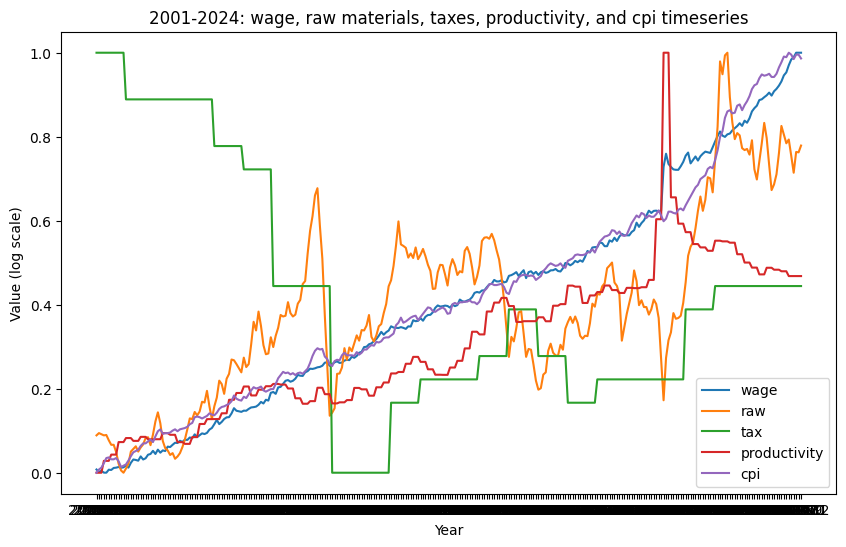

In [ ]:
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['Date'], data[var], label = var)
#plt.yscale('log')
plt.xlabel('Year')
plt.xticks(None)
plt.ylabel('Value (log scale)')
plt.title('2001-2024: wage, raw materials, taxes, productivity, and cpi timeseries')
plt.legend()


In [ ]:
data_2001_2010 = data[data['Date'].between('2001-01-01', '2010-12-01')]
data_2011_2020 = data[data['Date'].between('2011-01-01', '2020-12-01')]
data_2015_2024 = data[data['Date'].between('2015-01-01', '2024-12-01')]

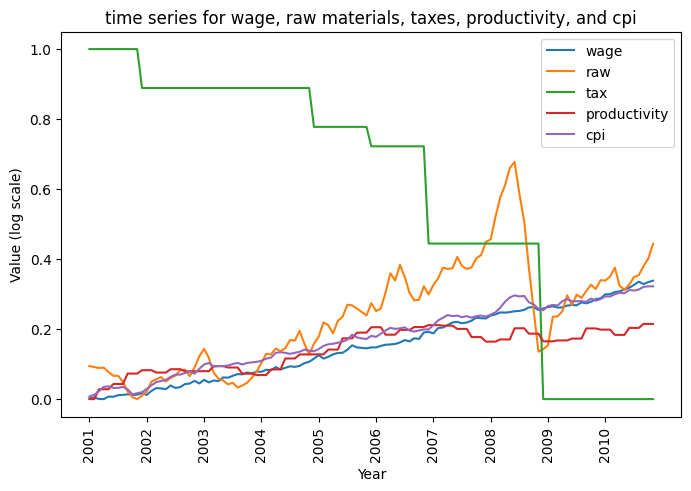

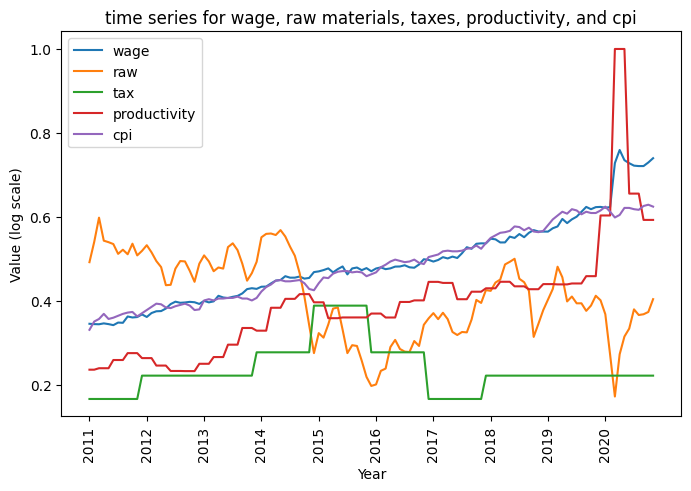

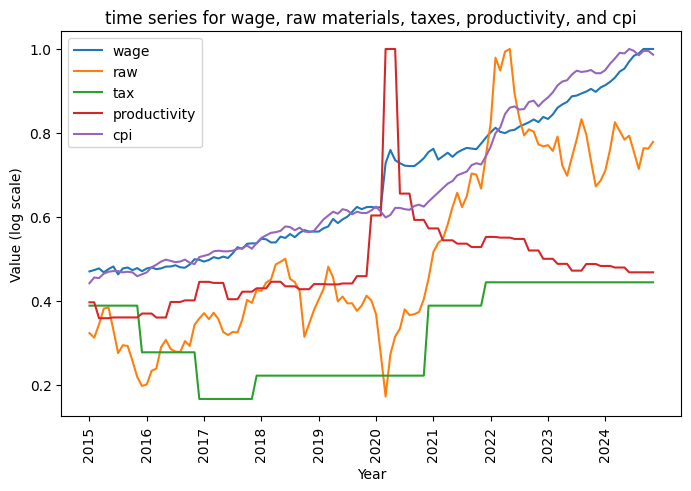

In [ ]:
decades = [data_2001_2010, data_2011_2020, data_2015_2024]

for decade in decades:
    plt.figure(figsize = (8, 5))

    for var in decade.columns[1:]:
        plt.plot(decade['Date'], decade[var], label = var)
        #plt.yscale('log')
        plt.xlabel('Year')

        x_tick_labels = [pd.to_datetime(d).year for d in decade['Date'][::12]]

        plt.xticks(decade['Date'][::12], x_tick_labels, rotation = 90)
        plt.ylabel('Value (log scale)')

        plt.title('time series for wage, raw materials, taxes, productivity, and cpi')
        plt.legend()

Lets have a look at some sections where there were significant changes (events?)in the variables. I remember being in my last year of my undergrad when a recession hit (fun times!). The last 5 years have been a bit of a roller coaster, I'll look into that section too.

In [ ]:
data_2007_2010 = data[data['Date'].between('2007-01-01', '2010-12-01')]
data_2019_2023 = data[data['Date'].between('2019-01-01', '2023-12-01')]

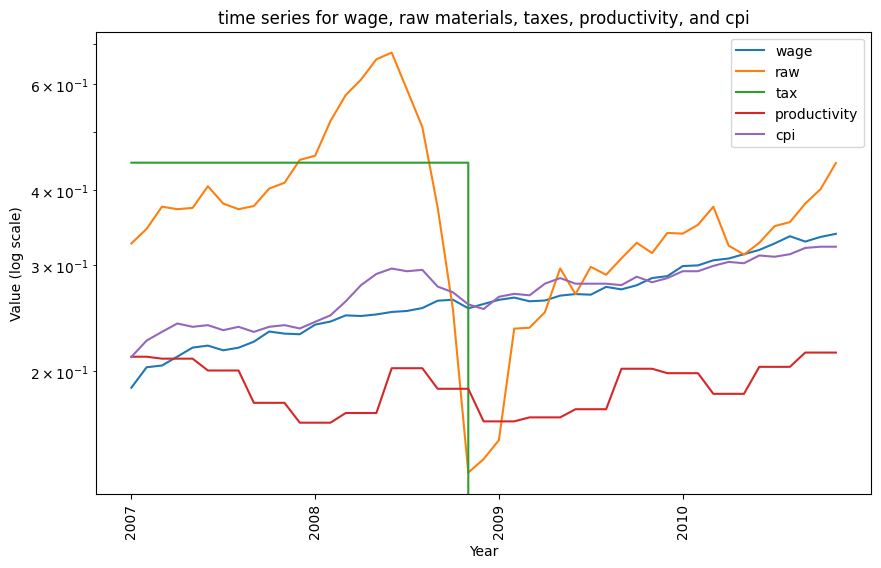

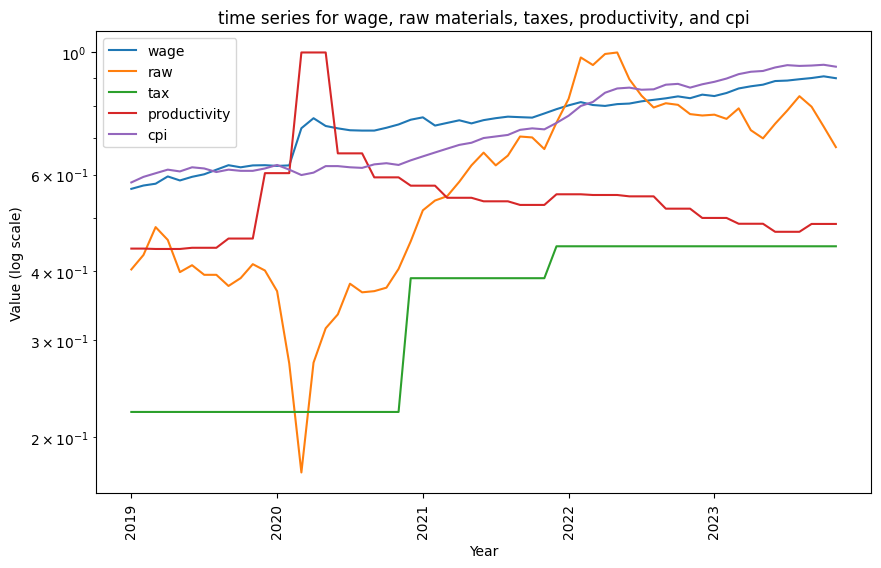

In [ ]:
events = [data_2007_2010, data_2019_2023]

for event in events:
    plt.figure(figsize = (10, 6))

    for var in event.columns[1:]:
        plt.plot(event['Date'], event[var], label = var)
        plt.yscale('log')
        plt.xlabel('Year')

        x_tick_labels = [pd.to_datetime(d).year for d in event['Date'][::12]]

        plt.xticks(event['Date'][::12], x_tick_labels, rotation = 90)
        plt.ylabel('Value (log scale)')

        plt.title('time series for wage, raw materials, taxes, productivity, and cpi')
        plt.legend()

Now lets see how the variables correlate with each other.

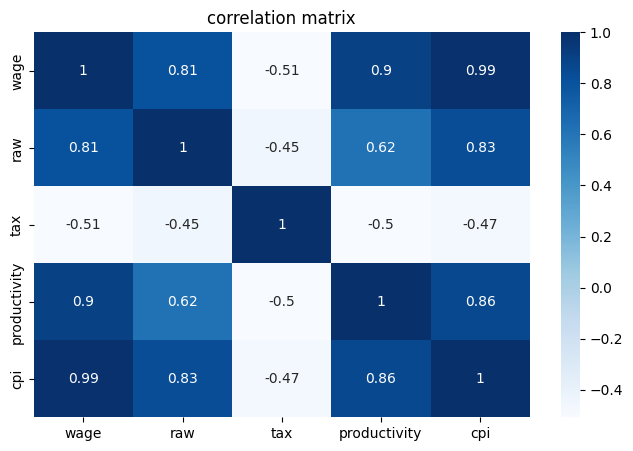

In [ ]:
cor_matrix = data[numerical_features].corr()

plt.figure(figsize = (8, 5))
sns.heatmap(cor_matrix, annot = True, cmap = 'Blues')
plt.title('correlation matrix')
plt.show()

### PCA Analysis



In [ ]:
pca = PCA(n_components = 4)
XPC = pca.fit_transform(data[features])

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Singular values:", pca.singular_values_)
print("Shape of XPC:", XPC.shape)

Explained variance ratio: [0.71735439 0.20170428 0.06895391 0.01198741]
Singular values: [6.91940221 3.66909749 2.14526604 0.89446713]
Shape of XPC: (288, 4)


PC1 - PC4 creates a new set of variables which themselves are combinations of the original variables. PC1 captures 75% of the overall variance, PC2 captures 20%, and so on.

<Figure size 500x500 with 0 Axes>

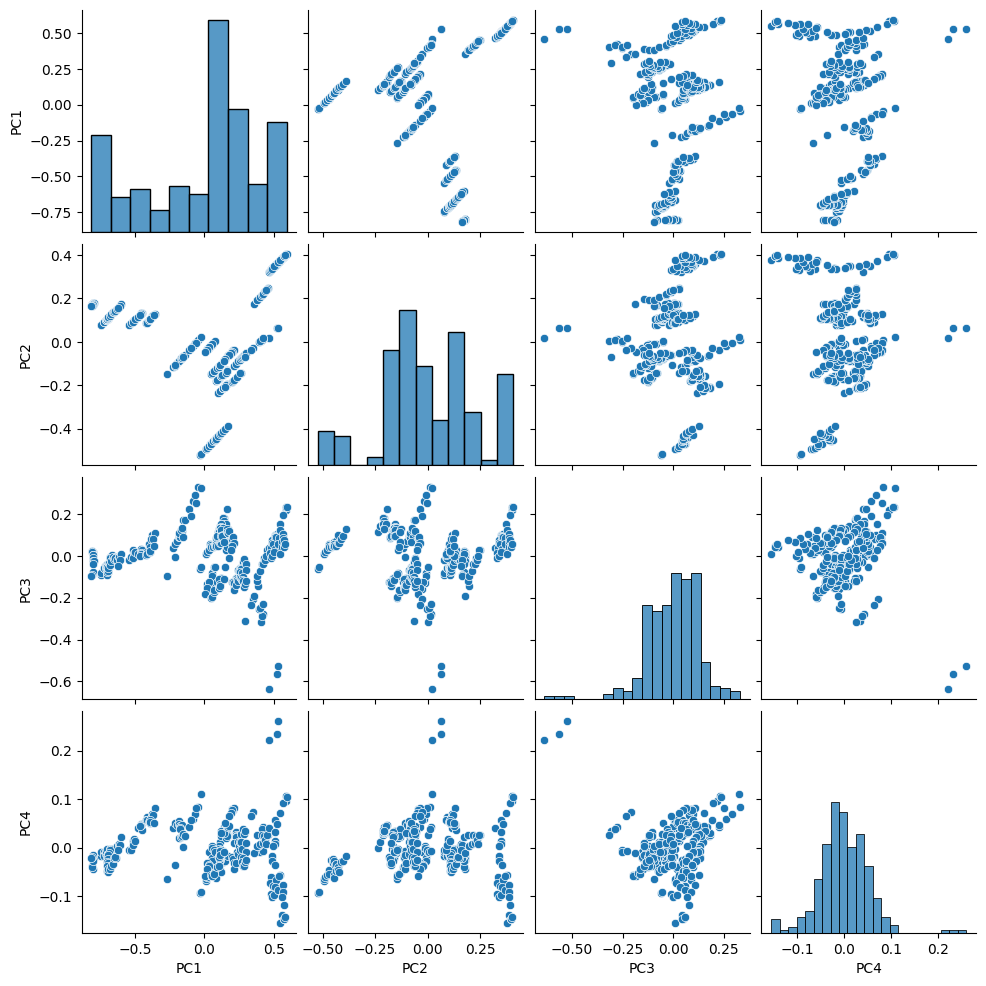

In [ ]:
plt.figure(figsize = (5, 5))

df = pd.DataFrame(XPC, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df['Date'] = data['Date']
sns.pairplot(df)
plt.show()

In [ ]:
clustering = DBSCAN(eps = 0.10, min_samples = 3).fit(XPC[:, [0, 1]])
labels = clustering.labels_

labels

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6], dtype=int32)

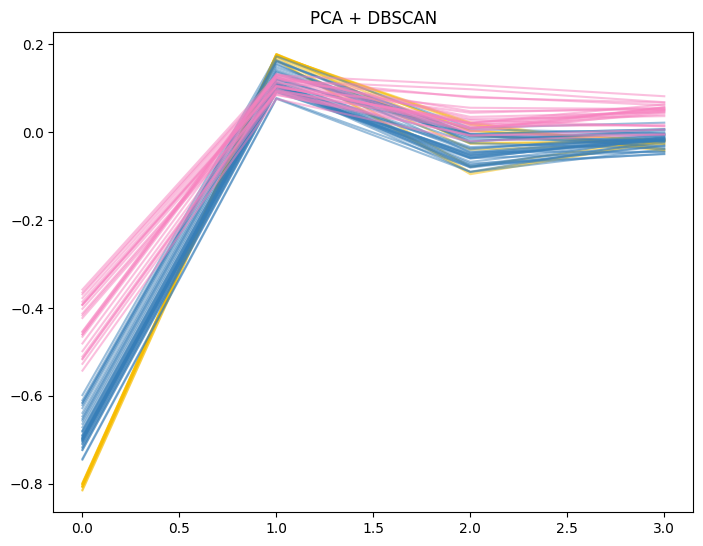

In [ ]:
plt.figure()
plt.axes([0, 0, 1, 1])
colors = ["#f7bd01", "#377eb8", "#f781bf"]
for l, color in zip(range(3), colors):
    plt.plot(XPC[labels == l].T, c=color, alpha=0.5, label=f'Cluster {l+1}')
# plt.legend(loc='best')
plt.title('PCA + DBSCAN')
plt.show()

I don't fully understand the whole pca thing... need to read further into this and look up time series uses.

## References

1. [Statistics Canada SDMX userguide](https://www.statcan.gc.ca/en/developers/sdmx/user-guide)
2. [OpenAI](https://chatgpt.com/)
3. [sklearn documentation](https://scikit-learn.org/1.6/)
4. [Towards Data Science: PCA Analysis](https://towardsdatascience.com/the-pca-trick-with-time-series-d40d48c69d28)